## TLE Parser

### Domain Specific Packaged Used

* https://pypi.org/project/ephem/ 
* https://federicostra.github.io/tletools/ 
* https://boto3.amazonaws.com/v1/documentation/api/latest/index.html

### Use
This notebook includes various functions to validate and or correct the Air Force TLE data and produce gridded data capable of ingesting into the compute engine

This notebook assumes that data is stored at the following locations relative to this notebook
- TLE data to be validated is stored at `../data/TLE/source`. This data is also precleaned of '\\' and repetatitive new lines using a command program like tr
- TLEs that can't be validated are witten directly to a file at `../data/TLE/errors`
- Validated TLE data is written at `../data/TLE/processed`



Valid data is written in CSV format using the following schema 

| Norad ID | Epoch Year | Epoch JD | TLE |   |
|----------|------------|----------|-----|---|
| INT      | INT        | FLOAT    | STR |   |


In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import ephem
import pathlib
from tletools.tle import TLE
import boto3
import requests
import multiprocessing
from joblib import Parallel, delayed

In [167]:
s3_client = boto3.client('s3')
WorkingFolder = pathlib.Path.cwd().joinpath('../data/TLE')
source_files = list(WorkingFolder.joinpath('source').glob('*.txt'))
processors = multiprocessing.cpu_count()

# Functions

In [329]:
def analyze_validation(file):
    
    """
    this function categorized the number of clean TLEs vs Dirty TLEs by summing the number of rows in the tle*.csv file and the number of lines that
    remain in the error file in tle*.e. It also categorizes the epoch year the cleaned TLEs span. 
    """
    
    df = pd.read_csv(file, index_col=0)

    with open(WorkingFolder.joinpath('errors', f'{file.name[:-4]}.e')) as f:
        # get number of TLEs in file
        dirty = len(f.readlines())/2

        stats = {
            'cleaned entries': len(df),
            'estimated unique entries': df.norad_id.nunique(),
            'dirty entries': dirty,
            'span': f'{df.epoch_year.min()}-{df.epoch_year.max()}',
            'file': f'{file.name[:-4]}'
        }


        return stats
            
        
def sum_string_digits(str):
    
    """
    this function takes a string and sums all numbers in the string, if not a number it skips the value in the string
    """
    
    return sum(int(x) for x in str if x.isdigit())

            
def checksum_tle_line(line):
    """
    this function validates tle line according documentation in https://celestrak.com/columns/v04n03/ , [alphas, . , +] are
    considered zeros. - are considered 1's. returns the bool of the ckecksum against the sum.
    """
    # get checksum value at the end of the line
    check_sum = line[-1]
    check_value = line[:-1].replace('-', '1')
    
    return int(check_sum) == sum_string_digits(check_value) % 10
    

def classify_tle_error(line1, line2):
    
    """
    this function classifies the error in the TLE
    A  "pk error" is whether the NORAD ID is not consistent between both lines of the TLE 
    An "id error" is when the international id doesn't conform to standard. 
    A  "missing data" is an error where the TLE line is not the required 69 characters long. 
    A  "checksum error" is where the TLE doesn't pass checksum. 
    """
    
    # noradid must match in line 1 and 2
    norad_ID_pass = line1[2:7] == line2[2:7]
    
    # iternational id must be 5 digits YYNNN and at least one letter
    international_ID_pass = line1[9:14].isdigit() and line1[14:17].strip().isalpha()
    
    # lines must be exactly 69 characters in length
    line1_length_pass = len(line1) == 69
    line2_length_pass = len(line2) == 69
    
    # see checksum_tle_line
    line1_checksum_pass = checksum_tle_line(line1)
    line2_checksum_pass = checksum_tle_line(line2)
    
    
    # classify logic
    if not norad_ID_pass:
        return 'pk error'
    if not international_ID_pass:
        return 'id error'
    elif not line1_length_pass or not line2_length_pass:
        return f"incorrect line size line1 {len(line1)}: line2 {len(line2)}"
    elif not line1_checksum_pass or not line2_checksum_pass:
        return f"checksum error line1 {not line1_checksum_pass}: line2 {not line2_checksum_pass}"
    else:
        return "None"
    
    
def classify_tle_file_errors(file):
    """
    this function applies the classify_tle_error on all TLEs in the tle*.e file and sums the types present in the file. 
    """
    
    with open(file) as error_file:
        
        tracks = []
        
        while True:
            first_line = error_file.readline().strip('\n')
            second_line = error_file.readline().strip('\n')
            
            if not first_line and not second_line:
                break
            
            tracks.append(classify_tle_error(first_line, second_line))
            
        track_errors = pd.Series(tracks, name=file.name[:-2]).value_counts()
        
        return track_errors
    

def upload_file(file, folder):
    
    """
    this function uploads file to the corpus, verify your aws config to have access to s3 bucket. This function is non optimized.
    """
    
    print(f'uploading {file.name}')
    s3_client.upload_file(str(file.absolute()), 'vault-data-corpus', folder + file.name)
    
    
def correct_tle(line1, line2):
    
    """
    the proponderence of errors detected are a column removed from both TLE lines and is the checksum value. 
    """

    first_line = line1.strip('\n')
    second_line = line2.strip('\n')
    
    e_class = classify_tle_error(first_line, second_line)

    # detect if line shortening has taken place prior column 62 in line 1 and 55 in line 2, if not TLE can be used without signifigant error
    if (
        e_class == 'incorrect line size line1 68: line2 68'
        and len(first_line.split()) == 9 # make sure extra spaces weren't added to line
        and first_line[23] == '.' # make sure decimal is in correct location
        and first_line[34] == '.' # make sure decimal is in correct location
        and first_line[50] in '+-' # make sure +- is in correct location
        and first_line[59] in '+-' # make sure +- is in correct location
        and first_line[61:64] == ' 0 '
        and len(second_line.split()) == 8 # make sure extra spaces weren't added to line
        and second_line[11] == '.' # make sure decimal is in correct location
        and second_line[20] == '.' # make sure decimal is in correct location
        and second_line[37] == '.' # make sure decimal is in correct location
        and second_line[46] == '.' # make sure decimal is in correct location
        and second_line[54] == '.' # make sure decimal is in correct location
        
    ):
        return (f"{first_line}{sum_string_digits(first_line.replace('-', '1')) % 10}\n", f"{second_line}{sum_string_digits(second_line.replace('-', '1')) % 10}\n")
    
    else:
        return (f"{first_line}\n", f"{second_line}\n")
        
        
        
def validate_tle_file(file, correct=False):
    """
    This function takes a a TLE files and validates each TLE in them using by using the Pyephem and TLE-tools library, 
    TLEs that can't be validated (corrected) are written back to an error file directory as `<inputfilename>.e` for further processing. 
    """
    
    print(f'processing {file.name}')
    with open(file) as tle_file:
        with open(WorkingFolder.joinpath(f'errors/{file.name[:-4]}.e'), 'w+') as error_file:
            i = 0
            tracks = []

            while True:
                # try to create a pyephem and TLE-tools objects, if fail write TLE string to error file and proceed to next TLE
                try:
                    # compose TLE strings for processing   
                    name = 'None\n'
                    firstline = tle_file.readline()
                    secondline = tle_file.readline()

                    # detect if EOF
                    if firstline == '' and secondline == '':
                        break

                    # if correct flag is True run TLE lines through correction function
                    if correct:
                        firstline, secondline = correct_tle(firstline, secondline)
                        
                    # run through pyephem for checksum and format error detection 
                    ephem.readtle(name, firstline, secondline)

                    # run through tle-tools for easy accessing norad_id, epoch year, epoch jd
                    track = TLE.from_lines(name, firstline.strip(), secondline.strip()).asdict()

                    # validate ranges for the following elemnts inclination 0 - 180, right ascention 0 - 360, 
                    # argument of pergee 0 - 360, mean anomoly 0 - 360

                    range_validation = [
                       0 <= track['inc'] <= 180,
                       0 <= track['raan'] <= 360, 
                       0 <= track['argp'] <= 360, 
                       0 <= track['M'] <= 360, 
                    ]

                    if not all(range_validation):
                        raise ValueError(f'elements out of range')

                    trackdict = {
                        'norad_id': track['norad'],
                        'epoch_year': track['epoch_year'],
                        'epoch_day': track['epoch_day'],
                        'tle': f"""{name}{firstline}{secondline}"""
                    }            

                    tracks.append(trackdict)

                except:
                    # write error
                    error_file.write(firstline)
                    error_file.write(secondline)

        print(f'completed processing {file.name}')    

        # create DataFrame and output to CSV
        df = pd.DataFrame(tracks)
        df.to_csv(f'../data/TLE/processed/{file.name[:-4]}.csv')

# Validation Analysis
For initial file validation run job with correct set to False

In [330]:
# run initial file validation jobs in parallel
correct = True
jobs = Parallel(n_jobs=processors-1)(delayed(validate_tle_file)(x, correct) for x in source_files)

/Users/aleksandrskruza/anaconda3/envs/JTF-191-Application/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [331]:
error_files = list(WorkingFolder.joinpath('errors').glob('*.e'))
processed_files = list(WorkingFolder.joinpath('processed').glob('*.csv'))

In [332]:
cleaned = Parallel(n_jobs=8)(delayed(analyze_validation)(x) for x in processed_files)
corpus = pd.DataFrame(cleaned).set_index('file')
corpus['percent error'] = (corpus['dirty entries'] / (corpus['dirty entries'] + corpus['cleaned entries'])) * 100

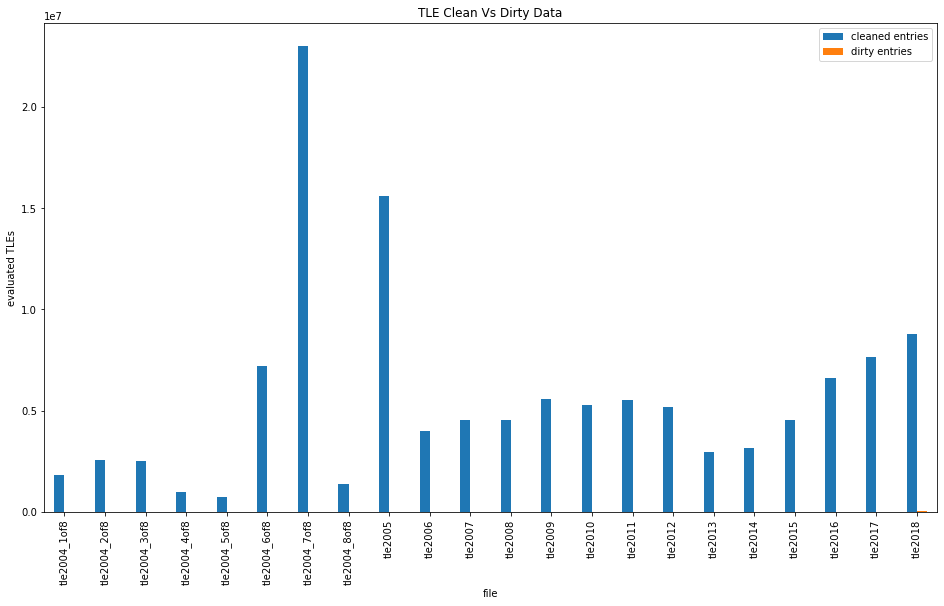

In [333]:
ax = corpus[['cleaned entries', 'dirty entries']].sort_index().plot(kind='bar', figsize=(16,9), title='TLE Clean Vs Dirty Data')
ax.set_ylabel('evaluated TLEs')
fig = ax.get_figure()
fig.savefig(f'TLE Clean Vs Dirty Data Corrected={correct}.png')

In [335]:
classified_files = Parallel(n_jobs=8)(delayed(classify_tle_file_errors)(x) for x in error_files)
errors = pd.DataFrame(classified_files)

corpus = pd.concat([corpus, errors.sort_index()], axis=1)

In [336]:
corpus.to_csv('../data/TLE/corpus.csv')